**Table of contents**<a id='toc0_'></a>    
- 1. [Problem 1: Optimal taxation with government consumption](#toc1_)    
- 2. [Problem 2: Labor adjustment costs](#toc2_)    
- 3. [Problem 3: Global optimizer with refined multi-start](#toc3_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

**Importing extensions**


In [1]:
import numpy as np
from scipy import optimize
from scipy.optimize import root
import sympy as sm
from scipy.optimize import root_scalar
from scipy.optimize import minimize_scalar
from sympy.solvers import solve
import matplotlib.pyplot as plt 
from tabulate import tabulate
import pandas as pd
from scipy.optimize import minimize
import seaborn as sns

plt.style.use("fivethirtyeight")

# Selecting a seed for the entire project
seed_num=1964
np.random.seed(seed_num)

## 1. <a id='toc1_'></a>[Problem 1: Optimal taxation with government consumption](#toc0_)


Consider a worker choosing hours of labor, $L\in[0,24]$, to maximize utility: 

$$
\begin{align*}
V(w,\tau,G)&=\max_{L\in[0,24]}\ln\left(C^{\alpha}G^{1-\alpha}\right)-\nu\frac{L^{2}}{2}\\&\text{s.t.}\\&C=\kappa+(1-\tau)wL
\end{align*}
$$

where 

* $C$ is *private* consumption with weight $\alpha\in(0,1)$.
* $\kappa > 0$ is the *free private* consumption component.
* $C = (1-\tau)wL$ is the *costly private* consumption component.
* $w > 0 $ is the real wage.
* $\tau \in (0,1)$ is the labor-income tax rate.
* $G > 0 $ is *government* consumption with weight $1-\alpha$.
* $\nu > 0$ is the disutility of labor scaling factor


The baseline parameters are:

$$
\begin{align*}
\alpha &= 0.5\\
\kappa &= 1.0\\
\nu &= \frac{1}{2\cdot16^2} \\
w &= 1.0 \\ 
\tau &= 0.30 \\
\end{align*}
$$

*****

**Question 1:** Verify that the optimal labor supply choice is $L^{\star}(\tilde{w}) =\frac{-\kappa+\sqrt{\kappa^{2}+4\frac{\alpha}{\nu}\tilde{w}^2}}{2\tilde{w}}$, where $\tilde{w} = (1-\tau)w$, for $G\in\left\{1.0 , 2.0\right\}$.

<font color='navy'> We seek to solve the optimal labor supply with numerical tools in python, this is done in the following code below. Having found the optimal value for the labor supply. With G=1 and G=2 we then insert the given parameter values from the question and compare the optimal labor supply results

In [2]:
### Solving numerically ###

# Defining baseline parameters
alpha = 0.5
kappa = 1.0
nu = 1 / (2 * 16**2)
w = 1.0
tau = 0.30

# Defining w_tilde
w_tilde = (1 - tau) * w

# Define the utility function
def utility(L, w_tilde, G):
    C = kappa + w_tilde * L
    return -(np.log(C**alpha * G**(1-alpha)) - nu * L**2 / 2)

# labor supply boundries
bounds = [(0, 24)]

# Initial guess for labor supply, trying with 12 thróugh the project.
initial_L = [12]

# G values
G_values = [1.0, 2.0]

# Running optimization process
for G in G_values:
    # Minimizing the negative utility function
    result = minimize(utility, initial_L, args=(w_tilde, G), bounds=bounds)

    # Printing the optimal labor supply 
    print(f"For G = {G}, the optimal labor supply L* is {result.x[0]}")


For G = 1.0, the optimal labor supply L* is 15.301205903705975
For G = 2.0, the optimal labor supply L* is 15.301196598595125


In [3]:
### Verify by inserting given values into the optimal function ###

# Compute L_star using the given formula
L_star = (-kappa + np.sqrt(kappa**2 + 4 * (alpha / nu) * w_tilde**2)) / (2 * w_tilde)

print(f"The optimal labor supply L* is {L_star}")


The optimal labor supply L* is 15.30165022719559


<font color='navy'> By comparing the results from the nummerical optimization to the given optimal labor supply with given parameters shows that the optimal labor supply choice from question 1) is the optimal choice

*****

**Question 2:** Illustrate how $L^{\star}(\tilde{w})$ depends on $w$.

<font color='navy'> We start by plotting the labor supply function as a function of the wage rate to better get a look at the relathionsip between them

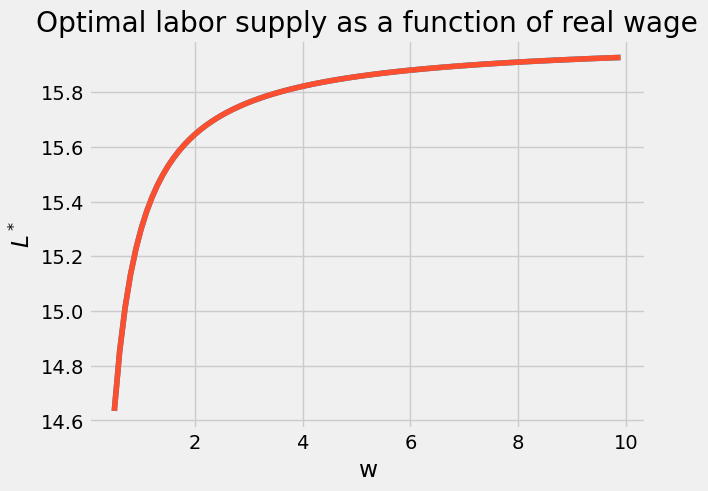

In [4]:
# Set range
w_range = np.arange(0.5, 10, 0.1)

# Initialize an array to store optimal labor supply choices
L_star_values = np.zeros((len(G_values), len(w_range)))

# Iterate over G and w values
for i, G in enumerate(G_values):
    for j, w in enumerate(w_range):
        # Calculate w_tilde
        w_tilde = (1 - tau) * w
        
        # Minimize the negative utility function
        result = minimize(utility, initial_L, args=(w_tilde, G), bounds=bounds)
        
        # Store the optimal labor supply choice
        L_star_values[i, j] = result.x[0]

# Plotting results
for i, G in enumerate(G_values):
    plt.plot(w_range, L_star_values[i], label=f'G = {G}')
plt.xlabel('w')
plt.ylabel('$L^*$')
plt.title('Optimal labor supply as a function of real wage')
plt.show()


<font color='navy'> Not that surprising, we see that the labor supply increase with the wage rate, and that there is a decreasing effect from wage increase on the labor supply

*****


We now consider a government, who chooses $\tau$ and spend all of the taxes on government consumption so:

$$
G = \tau w L^{\star}((1-\tau)w)
$$

**Question 3:** Plot the implied $L$, $G$ and worker utility for a grid of $\tau$-values.


<font color='navy'> We store the different tau values and iterate over them and find the implied labor supply and government spending for different tax rates to find the relathionsip


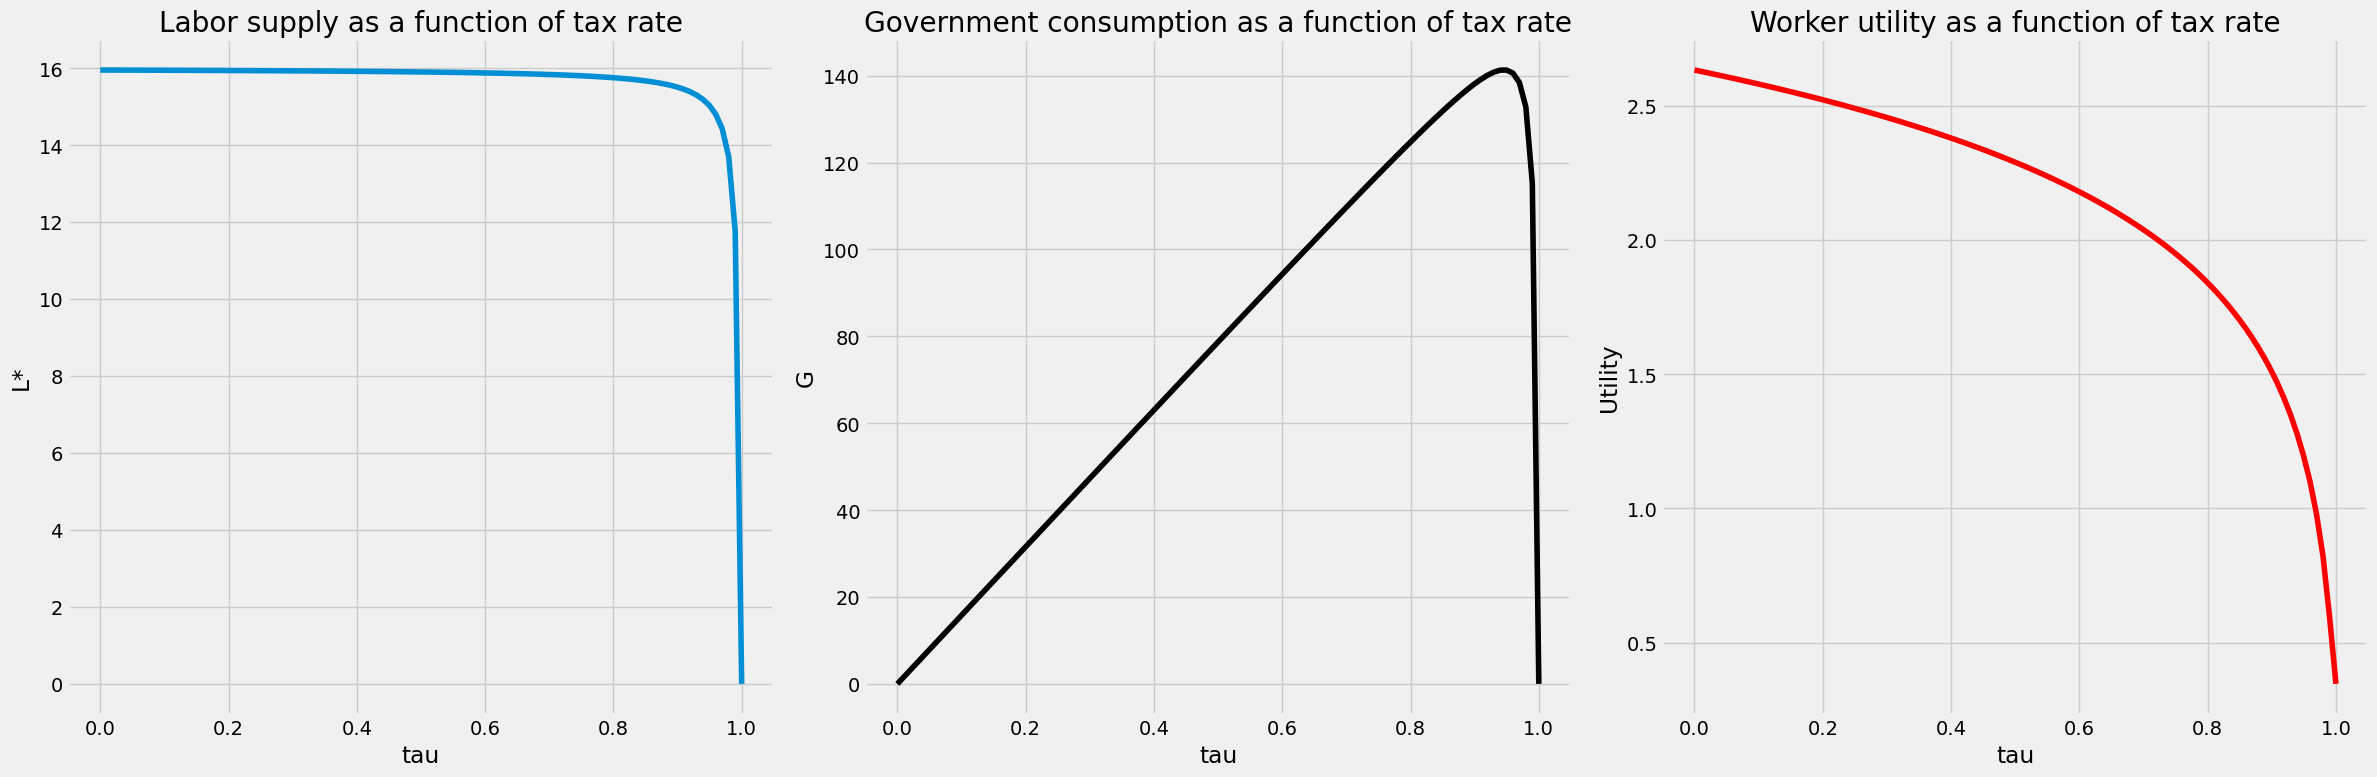

In [5]:
# Defining the utility function
def utility(L, w_tilde):
    C = kappa + w_tilde * L
    return -(np.log(C**alpha * G**(1-alpha)) - nu * L**2 / 2)

# Defining the labor supply bounds
bounds = [(0, 24)]

# Initial guess for labor supply
initial_L = [12]

# Setting range for tau, where the tax rate cant be less than zero or bigger than 1
tau_range = np.linspace(0, 1, 100)

# Initialize arrays to store optimal labor supply choices, government spending and worker utilities for different tau values
L_star_values = np.zeros(len(tau_range))
G_values = np.zeros(len(tau_range))
utility_values = np.zeros(len(tau_range))

# Iterate over tau values
for i, tau in enumerate(tau_range):
    w_tilde = (1 - tau) * w
        
    # Minimize the negative utility function
    result = minimize(utility, initial_L, args=(w_tilde,), bounds=bounds)
        
    # Store the optimal labor supply choice
    L_star_values[i] = result.x[0]
    
    # Calculate and store the government consumption
    G_values[i] = tau * w * L_star_values[i]
    
    # Calculate and store the worker utility
    utility_values[i] = -utility(L_star_values[i], w_tilde)

# Create the plots
fig, axs = plt.subplots(1, 3, figsize=(24, 8))

# Plot L_star
axs[0].plot(tau_range, L_star_values, label='L*')
axs[0].set_xlabel('tau')
axs[0].set_ylabel('L*')
axs[0].set_title('Labor supply as a function of tax rate')

# Plot G
axs[1].plot(tau_range, G_values, label='G', color='black')
axs[1].set_xlabel('tau')
axs[1].set_ylabel('G')
axs[1].set_title('Government consumption as a function of tax rate')

# Plot Utility
axs[2].plot(tau_range, utility_values, label='Utility', color='red')
axs[2].set_xlabel('tau')
axs[2].set_ylabel('Utility')
axs[2].set_title('Worker utility as a function of tax rate')

plt.tight_layout()
plt.show()


**<font color='black'> Labor Supply as a function of tax rate**

<font color='navy'> From this figure we see that there is a negative relathionsip between labor supply and the tax rate. We see that the effect intensify when the tax rate is above 80%. 

**<font color='black'> Government as a function of tax rate**

<font color='navy'> This figure shows that government spending increases with the tax rate until the tax rate becomes to high and the labor supply decreases drastically. This is in line with the results from the first figure, however the y-axis values might be a bit extreme. 

**<font color='black'> Worker utility as a function of tax rate** 

<font color='navy'> From this last figure we see that there is a negative relathionship between worker utility and the tax rate. 

*****

**Question 4:** Find the socially optimal tax rate $\tau^{\star}\in(0,1)$ maximizing worker utility. Illustrate your result.

<font color='navy'> We start by redifining the government spending (G) in the utility function, such that all taxes collected are spent on government expenditures. We are using scipy to find the numerical solution for the socially optimal tax rate. 

Optimal tax rate: 0.5025870417107053


C:\Users\mads0\AppData\Local\Temp\ipykernel_26632\1978216884.py:7: RuntimeWarning: divide by zero encountered in log
  return -np.log(C**alpha * G**(1-alpha)) + nu * L**2 / 2
C:\Users\mads0\AppData\Local\Temp\ipykernel_26632\1978216884.py:4: RuntimeWarning: invalid value encountered in double_scalars
  L_star = (-kappa + np.sqrt(kappa**2 + 4 * (alpha/nu) * w_tilde**2)) / (2 * w_tilde)


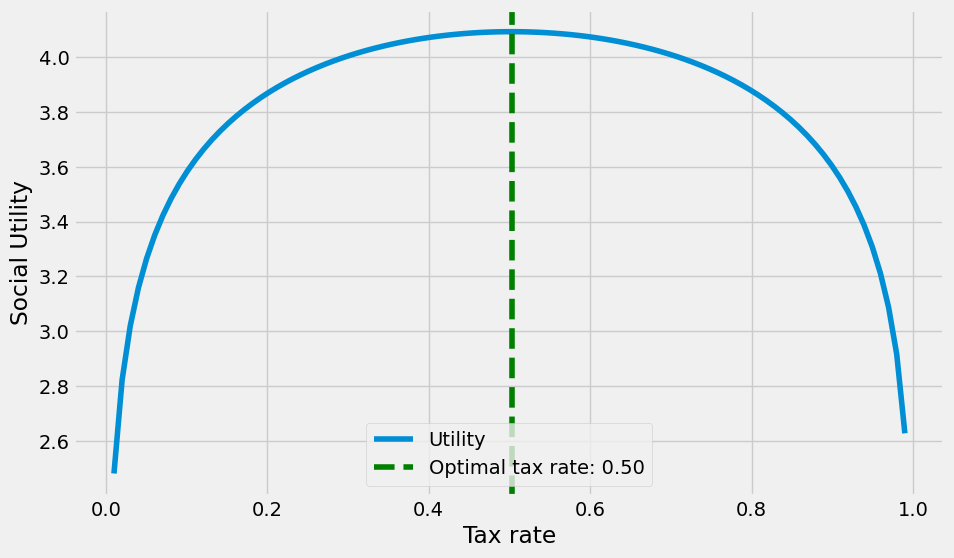

In [6]:
# Redefine the utility function
def utility(tau, w, alpha, kappa, nu):
    w_tilde = (1 - tau) * w
    L_star = (-kappa + np.sqrt(kappa**2 + 4 * (alpha/nu) * w_tilde**2)) / (2 * w_tilde)
    C = kappa + w_tilde * L
    G = tau * w * L_star
    return -np.log(C**alpha * G**(1-alpha)) + nu * L**2 / 2

L = 12 
tau_initial = [0.7] # initial guess for tau
tau_bounds = [(0.001, 0.999)] # bounds for tau

# Define the optimization problem
result = minimize(utility, tau_initial, args=(w, alpha, kappa, nu), bounds=tau_bounds)

# Get the optimal tax rate
tau_optimal4 = result.x[0]
print(f'Optimal tax rate: {tau_optimal4}')

# Plot the utility as a function of the tax rate
tau_values = np.linspace(0, 1, 100)
utility_values = [-utility(tau, w, alpha, kappa, nu) for tau in tau_values]

plt.figure(figsize=(10, 6))
plt.plot(tau_values, utility_values, label='Utility')
plt.axvline(tau_optimal4, color='g', linestyle='--', label=f'Optimal tax rate: {tau_optimal4:.2f}')
plt.xlabel('Tax rate')
plt.ylabel('Social Utility')
plt.legend()
plt.show()


<font color='navy'> We find that the optimal social tax rate is 50.3% which is plotted above, showing the social utility at this tax rate is approximately 1.85. Hence the new government budget constraint has yielded a higher utility than from question 1.3)

*****

A more general preference formulation for the worker is:

$$
\begin{align*}
\mathcal{V}(w,\tau,G)&=\max_{L\in[0,24]}\frac{\left[ \left( \alpha C^{\frac{\sigma-1}{\sigma}}+(1-\alpha) G^{\frac{\sigma-1}{\sigma}} \right)^{\frac{\sigma}{\sigma-1} }\right]^{1-\rho}-1}{1-\rho}- \nu\frac{L^{1+\varepsilon}}{1+\varepsilon},\,\,\,\varepsilon,\rho,\sigma>0,\,\,\,\rho,\sigma\neq1\\&\text{s.t.}\\&C=\kappa+(1-\tau)wL
\end{align*}    
$$

Optimal labor supply is now $L^{\star}(\tilde{w},G)$.

Questions 6 must be answered with the general formulation, and for 2 different set of parameters:

- Set 1:  $\sigma = 1.001$, $\rho = 1.001$ and $\varepsilon = 1.0$.
- Set 2:  $\sigma = 1.5$, $\rho = 1.5$ and $\varepsilon = 1.0 $.

**Question 5:** Find the $G$ that solves $G = \tau w L^{\star}((1-\tau)w,G)$ using the $\tau$ found in question 4.

*Hint: First write code that solves the worker problem for given values of $G$ and $\tau$. Then find the correct G based on this.*

<font color='navy'> We start by redefining the utility function to the new one and split it up into two terms. Having done this we use scipy.minimize to find the best labor supply results and store them as L_star. We do the same for G values and lastly iterate through the different parameter sets.

In [7]:
# define the utility function
def utility(L, w, tau, G, alpha, sigma, rho, epsilon, kappa, nu):
    C = kappa + (1-tau)*w*L
    if C <= 0 or G <= 0:
        return -np.inf
    term1 = ((alpha * C**((sigma-1)/sigma) + (1-alpha) * G**((sigma-1)/sigma)) ** (sigma/(sigma-1)))**(1-rho) - 1
    term2 = nu * L**(1+epsilon) / (1+epsilon)
    return - (term1 / (1-rho) - term2)

# define the optimal labor supply function
def L_star(w, tau, G, alpha, sigma, rho, epsilon, kappa, nu):
    result = minimize(utility, initial_L, args=(w, tau, G, alpha, sigma, rho, epsilon, kappa, nu), bounds=L_bounds)
    return result.x[0]

# define the function to solve for G
def solve_for_G(G, w, tau, alpha, sigma, rho, epsilon, kappa, nu):
    w_eff = w * (1 - tau)
    L_optimal = L_star(w_eff, tau, G, alpha, sigma, rho, epsilon, kappa, nu)
    return [G - tau * L_optimal]

# define parameter values
alpha = 0.5 
kappa = 1.0
w = 1.0
nu = 1 / (2 * 16**2)
tau = tau_optimal4  # Found in question 1.4

# define the labor supply bounds
L_bounds = [(0, 24)]

# initial guess for labor supply
initial_L = [12]

# initial guess for G
initial_G = [1.5]

# define parameter sets
param_sets = [
    {"sigma": 1.001, "rho": 1.001, "epsilon": 1.0}, 
    {"sigma": 1.5, "rho": 1.5, "epsilon": 1.0}
]

# iterate through parameter sets
for i, params in enumerate(param_sets, 1):
    solution = root(solve_for_G, initial_G, args=(w, tau, alpha, params["sigma"], params["rho"], params["epsilon"], kappa, nu), method='krylov')
    G_solution = solution.x[0]
    print(f"Set {i} Government consumption that balances the budget: {G_solution}")


Set 1 Government consumption that balances the budget: 7.084806675430945
Set 2 Government consumption that balances the budget: 4.627198701594762


<font color='navy'> We see that the Government consumption that solves the question with our tax rate from question 1.4 is: G=7.08 for set 1 values, and G=4.63 for the set 2 values. 

$\sigma$: Is the elasticity of substitution between government spending and private consumption. Easier substitution between the two goods could lead to a lower labor supply when the agent can achieve a similar utility by substituting towards government consumption. This would lead to a lower G, and hence could explain why parameter set2 has a lower G value than set 1.

$\rho$: Is the relative risk aversion, a lead in this would lead to increasing absolute risk aversion (IRRA) which could lead to a decrease in the labor supply. Hence we got two effects from increase the parameters suggesting a lower Government Consumption for the set2 values. 

*****

**Question 6:** Find the socially optimal tax rate, $\tau^{\star}$, maximizing worker utility, while keeping $G = \tau w L^{\star}((1-\tau)w,G)$.

*****

<font color='navy'> We keep the different parameter sets and use minimize.scalar to replace the maximum utility each time it finds a higher value and replace it to find the socially optimal tax rate.

The optimal tax rate for sigma = 1.001 and rho = 1.001 is tau = 0.5148


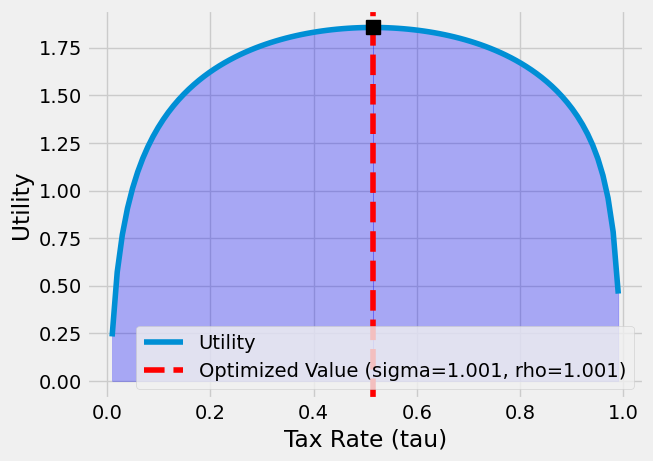

The optimal tax rate for sigma = 1.5 and rho = 1.5 is tau = 0.4654


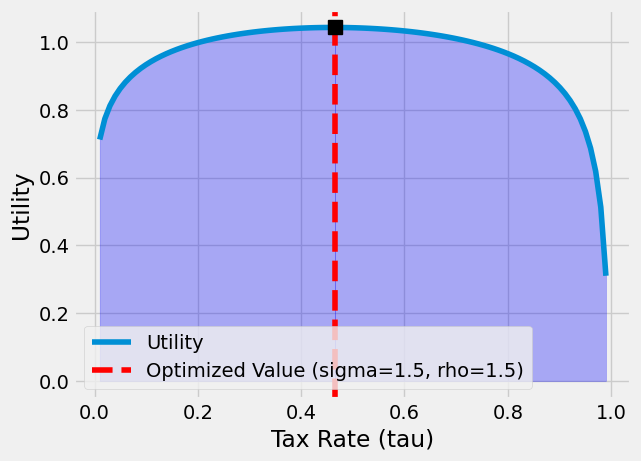

In [8]:
# Define parameters
sigma_values = [1.001, 1.5]
rho_values = [1.001, 1.5]
epsilon = 1.0
alpha = 0.5
kappa = 1.0
nu = 1 / (2 * 16 ** 2)
w = 1
L_guess = 12

# Define utility function
def utility_set1(L, alpha, tau, w, nu, G, sigma, rho, epsilon):
    C = kappa + (1 - tau) * w * L
    utility = ((alpha * C**((sigma - 1) / sigma) + (1 - alpha) * G**((sigma - 1) / sigma))**(sigma / (sigma - 1)))**(1 - rho) - 1
    utility /= 1 - rho
    utility -= nu * L**(1 + epsilon) / (1 + epsilon)
    return utility

# Define the equation for finding G for Set 1
def equation_G_set1(G, tau, w, alpha, sigma, rho, epsilon, kappa, nu, L_guess):
    L_star = minimize_scalar(lambda L: -utility_set1(L, alpha, tau, w, nu, G, sigma, rho, epsilon), bounds=(0, 24), method='bounded').x
    return G - tau * w * L_star

# Perform optimization for each parameter combination
for sigma, rho in zip(sigma_values, rho_values):
    optimal_tau = None
    max_utility = float('-inf')

    tau_values = np.linspace(0.01, 0.99, 100)
    utility_values = []
    for tau in tau_values:
        G = minimize_scalar(lambda G: abs(equation_G_set1(G, tau, w, alpha, sigma, rho, epsilon, kappa, nu, L_guess)), bounds=(0, 24), method='bounded').x
        L_star = minimize_scalar(lambda L: -utility_set1(L, alpha, tau, w, nu, G, sigma, rho, epsilon), bounds=(0, 24), method='bounded').x
        utility = utility_set1(L_star, alpha, tau, w, nu, G, sigma, rho, epsilon)
        utility_values.append(utility)

        if utility > max_utility:
            max_utility = utility
            optimal_tau = tau

    # Print the optimal tau value
    print(f"The optimal tax rate for sigma = {sigma} and rho = {rho} is tau = {optimal_tau:.4f}")

    # Create the plot
    fig, ax = plt.subplots()
    ax.plot(tau_values, utility_values, label='Utility')
    ax.axvline(x=optimal_tau, linestyle='--', color='red', label=f'Optimized Value (sigma={sigma}, rho={rho})')
    ax.plot(optimal_tau, max_utility, marker='s', color='black', markersize=10)
    ax.fill_between(tau_values, utility_values, where=(tau_values <= optimal_tau), color='blue', alpha=0.3)
    ax.fill_between(tau_values, utility_values, where=(tau_values >= optimal_tau), color='blue', alpha=0.3)
    ax.set_xlabel('Tax Rate (tau)')
    ax.set_ylabel('Utility')
    ax.legend()
    plt.show()


<font color='navy'> We see that the new optimal tax rate for parameter set 1 is tau = 0.51 = 51%

For the parameter set 2 the optimal tax rate is tau = 0.47 = 47%

The tax rate falls when the parameters increases. 

When sigma increases the disutility of labor increases, and leads to lower labor supply. This could lead the government to incentivize the labor force with a lower tax rate. 

When rho increases, the risk-aversion increases, meaning that the consumer derives less utility from consumption of extra goods and government spending compared to a less risk-averse consumer. Hence, the risk-averse consumer might prefer a lower tax rate allowing more personal consumption and less risk. Which as well as sigma could explain the lower tax rate. 

*****

## 2. <a id='toc2_'></a>[Problem 2: Labor adjustment costs](#toc0_)

You own a hair salon. You employ hairdressers, $\ell_t$, to produce haircuts, $y_t = \ell_t$.

The wage for each haridresser is $w$.

The demand for haircuts implies that the price of haircuts you can charge is $p_t = \kappa_t y_t^{-\eta}$, where $\kappa_t$ is a demand-shock and $\eta \in (0,1)$ measures the elasticity of demand.

Profits are:

$$
\Pi_t = p_t y_t - w \ell_t = \kappa_t \ell_t^{1-\eta} - w \ell_t
$$

Baseline parameters are:
- $\eta = 0.5$
- $w = 1.0$

**Question 1:** Verify numerically that $\ell_{t}=\left(\frac{(1-\eta)\kappa_{t}}{w}\right)^{\frac{1}{\eta}}$ maximises profits, for $\kappa\in\left\{1.0 , 2.0\right\}$.

<font color='navy'> We set up a similar framework as we did in question 1.1) where we start by running a numerical optimization and afterwards compare the results to the given formula with the parameter values.

For kappa = 1.0:
Maximum profit is 0.24999878781612067 at lt = 0.25110220440881764
Proposed solution gives profit 0.25 at lt = 0.25
-----


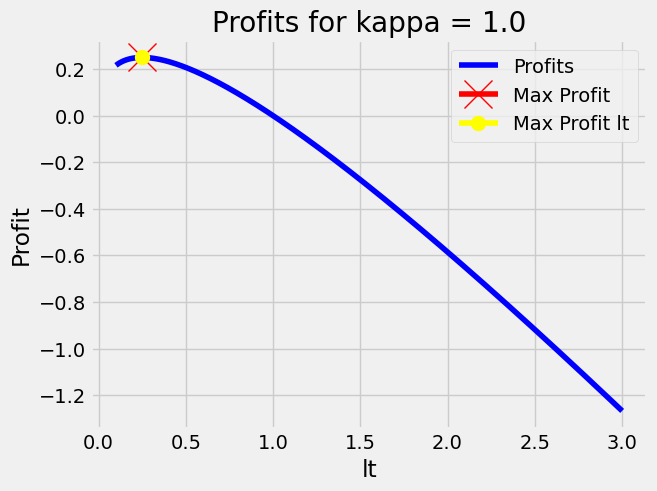

For kappa = 2.0:
Maximum profit is 0.9999998394224283 at lt = 1.0008016032064129
Proposed solution gives profit 1.0 at lt = 1.0
-----


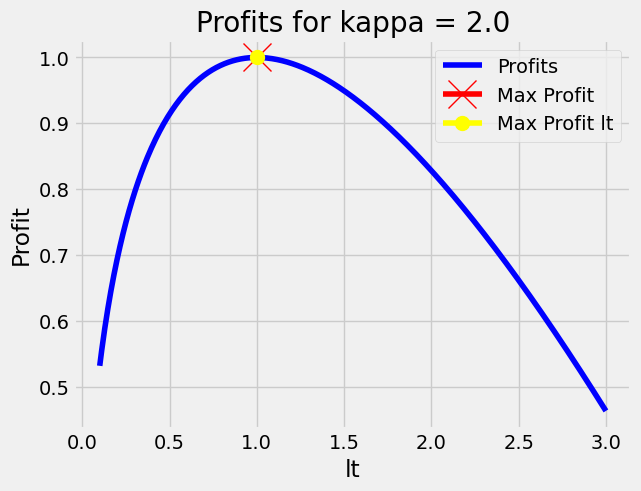

In [9]:
np.random.seed(seed_num)
# Define the parameters
eta = 0.5
w = 1.0
kappas = [1.0, 2.0]

# Define the profit function
profit_func = lambda ell, kappa: kappa * ell**(1-eta) - w * ell

# The proposed solution function
solution_func = lambda kappa: ((1 - eta) * kappa / w) ** (1 / eta)

for kappa in kappas:
    # Create a range of possible lt values
    lt_values = np.linspace(0.1, 3.0, 500)
    
    # Calculate profits for these values
    profits = profit_func(lt_values, kappa)
    
    # Find the maximum profit and corresponding lt value
    max_profit_index = np.argmax(profits)
    max_profit_lt = lt_values[max_profit_index]
    max_profit = profits[max_profit_index]
    
    # Calculate the lt value from the proposed solution
    solution_lt = solution_func(kappa)
    solution_profit = profit_func(solution_lt, kappa)

    # Print the results
    print(f"For kappa = {kappa}:")
    print(f"Maximum profit is {max_profit} at lt = {max_profit_lt}")
    print(f"Proposed solution gives profit {solution_profit} at lt = {solution_lt}")
    print("-----")
    
    
    # Plot the results
    plt.figure()
    plt.plot(lt_values, profits, label='Profits', color="blue")
    plt.plot(max_profit_lt, max_profit, marker='x', markersize=20, color="red", label='Max Profit')
    plt.plot(max_profit_lt, max_profit, marker="o", markersize=10, color="yellow", label='Max Profit lt')
    plt.legend()
    plt.xlabel('lt')
    plt.ylabel('Profit')
    plt.title(f"Profits for kappa = {kappa}")
    plt.grid(True)
    plt.show()


<font color='navy'> We have marked the nummerical solution with a red cross and the optimal l given with the correct values marked as a yellow circle. From both plots we see that they lay on top of each other, hence they yield the same solution for both Kappa=1 and Kappa=2. We therefore verify that the given solution is the correct one.

*****

We now consider a *dynamic* version of the model.

* The demand-shock is a so-called AR(1) in logs, 

$$
\log \kappa_{t} = \rho \log \kappa_{t-1} + \epsilon_{t},\,\,\, \epsilon_{t+1} \sim \mathcal{N}(-0.5\sigma_{\epsilon}^2,\sigma_{\epsilon})
$$

* Any hiring or firing implies a fixed adjustment cost, $\iota > 0 $.
* Future profits are discounted with a monthly factor of $R \in (0,1)$.

The initial demand shock is $\kappa_{-1} = 1$ and the planning horizon is 10 years, i.e. 120 months so $t \in \{0,1,2,\dots,119\}$. Initially you don't have any employees, $\ell_{-1}=0$


The *ex post* value of the salon is *conditional* on the shock series is:

$$
h(\epsilon_0,\epsilon_1,\dots,\epsilon_{119}) = \left[\sum_{t=0}^{119}R^{-t}\left[\kappa_{t}\ell_{t}^{1-\eta}-w\ell_{t}-\boldsymbol{1}_{\ell_{t}\neq\ell_{t-1}}\iota\right]\right]
$$

The *ex ante* expected value of the salon can be approximated by

$$
H = \mathbb{E}[h(\epsilon_0,\epsilon_1,\dots,\epsilon_{119})] \approx \frac{1}{K}\sum_{k=0}^{K} h(\epsilon_0^k,\epsilon_1^k,\dots,\epsilon_{119}^k)
$$

where each $k\in\{0,1,\dots,K-1\}$ is a random shock series. Maximizing profitability means maximizing $H$.


Baseline parameters are: 

- $\rho = 0.90$
- $\iota = 0.01$
- $\sigma_{\epsilon} = 0.10$
- $R = \left(1+0.01\right)^{1/12}$

**Question 2:** Calculate $H$ if the policy  $\ell_{t}=\left(\frac{(1-\eta)\kappa_{t}}{w}\right)^{\frac{1}{\eta}}$ from question 1 is followed. Choose $K$ so the approximation is good enough to not affect your results substantially.

<font color='navy'> We start by defining the new policy function and set K = 1000. We have created a function with several delta values so are able to adjust it for the next question. In this question we set delta1 and delta2 equal to zero, hence this is the simple version.

In [10]:
# Define the parameters
eta = 0.5
w = 1.0
rho = 0.90
iota = 0.01
sigma_eps = 0.10
R = (1 + 0.01) ** (1 / 12)
T = 120  # months
K = 1000  # number of shock series

def function_(Delta1, Delta2, seed=None):

    # Setting seed
    np.random.seed(seed)

    # Define the policy function
    policy_func = lambda kappa: ((1 - eta) * kappa / w) ** (1 / eta)

    # Initialize the array to store total profits for each shock series
    total_profits = np.zeros(K)

    # Generate K shock series
    for k in range(K):
        kappa = np.zeros(T+1)
        kappa[0] = 1  # kappa_{-1} = 1
        ell_prev = 0  # initially no employees
        total_profit = 0

        # Generate T shocks
        for t in range(T):
            # AR(1) process for log(kappa)
            eps = np.random.normal(loc=-0.5*sigma_eps**2, scale=sigma_eps)
            kappa[t+1] = np.exp(rho * np.log(kappa[t]) + eps)

            # Calculate lt_star according to policy
            ell_star = policy_func(kappa[t+1])

            # Apply the threshold policy: 
            # If ell_star - ell_prev > Delta1, hire new hairdressers.
            # If ell_prev - ell_star > Delta2, fire some hairdressers.
            # Otherwise, keep the same number of hairdressers.
            if np.abs(ell_star - ell_prev) > Delta1:
                ell_t = ell_star
            elif (ell_prev - ell_star) > Delta2:
                ell_t = ell_star
            else:
                ell_t = ell_prev

            # Calculate profit
            profit = kappa[t+1] * ell_t ** (1 - eta) - w * ell_t
            # Consider adjustment costs
            if ell_t != ell_prev:
                profit -= iota

            # Update total profit
            total_profit += profit / R ** t

            # Update previous number of employees
            ell_prev = ell_t

        # Store the total profit for this shock series
        total_profits[k] = total_profit

    # Calculate H
    H_threshold_policy = total_profits.mean()

    return H_threshold_policy, total_profits

# Function

# Delta1 = 0
Delta1 = 0
# Delta2 = 0
Delta2 = 0

H_value, H_values = function_(Delta1, Delta2, seed=seed_num)

# Print the result
print(f"The expected value of the salon H is {H_value}")

The expected value of the salon H is 27.78984423986379


<font color='navy'> We see that the maximum expected value of the Salon in this case is 27.79

*****

Next, we consider policies on the form:

$$

\ell_{t}=\begin{cases}
\ell_t^{\ast}  & \text{if }\left|\ell_{t-1}-\ell_t^{\ast} \right|>\Delta\\
\ell_{t-1} & \text{else }
\end{cases}
\\
\text{where}\,\,\ell_t^{\ast} = \left(\frac{(1-\eta)\kappa_{t}}{w}\right)^{\frac{1}{\eta}} \\

$$
With $\Delta \geq 0$ and $\Delta = 0$ being the previous policy.



**Question 3:** Calculate $H$ if the policy above was followed with $\Delta = 0.05$. Does it improve profitability?

<font color='navy'> We now set delta1 = 0.05 and run the optimization process again:

In [11]:
# Function

# Delta1 = 0 which afer new plocy restriction
Delta1 = 0.05
# Delta2 = 0 which is firing
Delta2 = 0

H_value, H_values = function_(Delta1, Delta2, seed=seed_num)

# Print the result
print(f"The expected value of the salon H with the new policy is {H_value}")

The expected value of the salon H with the new policy is 28.171144460248147


<font color='navy'> With delta1 = 0.05 we get a value of 28.1, which is above the value from question 2.2) (27.79) Hence the new policy improves profitiability 

*****

**Question 4:** Find the optimal $\Delta$ maximizing $H$. Illustrate your result.

<font color='navy'> In this question we create a new function without restrictions on the delta value and optimize it:

In [12]:
K = 1000  # number of shock series to 

# Initialize an array to store the optimal H and Delta
optimal_H = -np.inf
optimal_Delta = None

# Define the range of Delta to search over
Delta_values = np.linspace(0, 1, 101)

# Store all H values for illustration
H_values = []

# Iterate over all Delta
for Delta in Delta_values:
    # Initialize the array to store total profits for each shock series
    total_profits = np.zeros(K)

    # Our function where we insert Delta in Delta1
    H_value, H_values_NOT = function_(Delta, Delta2, seed=seed_num)
    H_values.append(H_value)

    # Update the optimal Delta and H if this H is larger than the current optimal H
    if H_value > optimal_H:
        optimal_H = H_value
        optimal_Delta = Delta


The optimal Delta is 0.09 with the corresponding H being 28.23809697444665


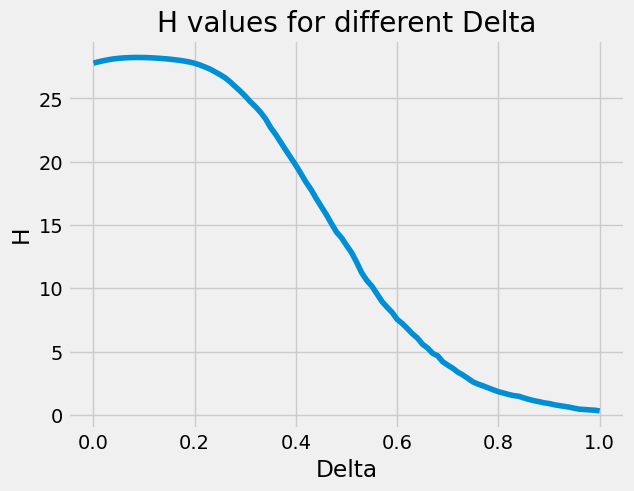

In [13]:
# Print the optimal Delta and the corresponding H
print(f"The optimal Delta is {optimal_Delta} with the corresponding H being {optimal_H}")

# Illustrate the result
plt.plot(Delta_values, H_values)
plt.xlabel("Delta")
plt.ylabel("H")
plt.title("H values for different Delta")
plt.show()


<font color='navy'> From the output and Figure above, we see that the optimal Delta = 0.09 and the corresponding value of the salon H=28.24 which is above the solution from question 2.3 - hence this is the best solution so far.

*****


**Question 5:** Suggest an alternative policy you believe might improve profitability. Implement and test your policy.



<font color='navy'> We implement a new policy where we implement firing adjustment as Delta2 for the hairdressers. Where we keep delta1 equal to the optimal value from question 2.4 for better comparison with before the new policy. 

In [14]:
#THRESSHOLD SOLUTION

K = 1000  # number of shock series

# Define the hiring and firing thresholds
Delta1 = optimal_Delta  # hiring threshold
Delta2 = np.linspace(0,0.2,41)  # firing threshold
list_H_value=[]

# Finding optimal value for firing value:
for x in Delta2:
    # Function
    H_value, H_values = function_(Delta1, x, seed=seed_num)
    list_H_value.append(H_value)

The expected value of the salon following the threshold hiring is 28.516783437426252 with an optimal firing value of 0.075


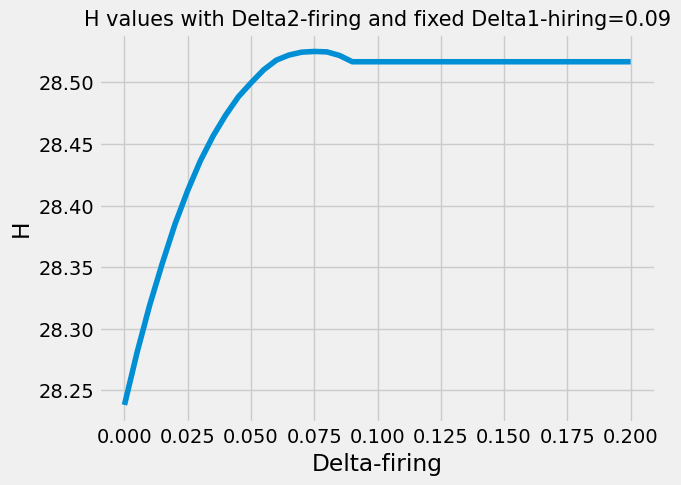

In [15]:
print(f"The expected value of the salon following the threshold hiring is {H_value} with an optimal firing value of {Delta2[list_H_value.index(max(list_H_value))]}")

plt.xlabel("Delta-firing")
plt.ylabel("H")
plt.title(f"H values with Delta2-firing and fixed Delta1-hiring={optimal_Delta}",size=15)
plt.plot(Delta2,list_H_value)

<font color='navy'>  The firing rate is set so it can't be bigger than the hiring rate - therefore we see a straight line after 0.09. The optimum is clearly smaller than 0.09 which is optimum for hiring. The firing rate is 0.075. Further we see that the optimal is found at H = 28.52, hence implementing the adjustment rate of firing might suggest a better policy than the original from the question.

*****

## 3. <a id='toc3_'></a>[Problem 3: Global optimizer with refined multi-start](#toc0_)

We consider the Griewank function:

$$ f(\boldsymbol{x}) = \sum^n_{i=1} \frac{x^2_i}{4000}-\prod^n_{i=1}\cos\left(\frac{x_i}{\sqrt{i}}\right)+1$$

The **global minimum** of this function is $f(0,0) = 0$ (remember: $\cos(0)=1$).<br>
But the function also have a lot of **local minima**.

In [16]:
def griewank(x):
    return griewank_(x[0],x[1])
    
def griewank_(x1,x2):
    A = x1**2/4000 + x2**2/4000
    B = np.cos(x1/np.sqrt(1))*np.cos(x2/np.sqrt(2))
    return A-B+1

A **refined global optimizer with multi-start** is:

1. Choose *bounds* for $\mathbf{x}$ and *tolerance* $\tau > 0$.
2. Choose number of *warm-up iterations*, $\underline{K} > 0$ and *maximum number of iterations*, $K > \underline{K}$.
3. In each iteration for $k \in \{0,1,\dots,K-1\}$:

    A. Draw random $\mathbf{x}^k$ uniformly within chosen bounds.

    B. If $k < \underline{K}$ go to step E.

    C. Calculate $\chi^k = 0.50\cdot\frac{2}{1+\exp((k-\underline{K})/100)}$  

    D. Set $\mathbf{x}^{k0} = \chi^k \mathbf{x}^k + (1-\chi^k)\mathbf{x}^{\ast} $

    E. Run optimizer with $\mathbf{x}^{k0}$ as initial guess and $\mathbf{x}^{k\ast}$ as result.

    F. Set $\mathbf{x}^{\ast} = \mathbf{x}^{k\ast}$ if $k = 0$ or $f(\mathbf{x}^{k\ast}) < f(\mathbf{x}^{\ast})$

    G. If $f(\mathbf{x}^{\ast}) < \tau$ go to step 4.

4. Return the result $\mathbf{x}^{\ast}$.

As settings we choose:

* $x_1,x_2 \in  [-600,600]$
* $\tau = 10^{-8}$
* $\underline{K}=10$
* $K=1000$

The optimizer in Step 3.E is `BFGS` with a tolerance of $\tau$.

**Question 1:** Implement the refined global optimizer with multi-start. Illustrate how the effective initial guesses $\mathbf{x}^{k0}$ vary with the iteration counter $k$.½

<font color='navy'> We implement the refined global optimizer as stated in the question. We then illustrate the convergence process in a plot

In [17]:
bounds = np.array([-600,600])
tau = 10**(-8)
K_ = 10
K = 1000

# Building the code as instructed

def refined_global_optimizer(K,K_,bounds,tau,seed=None):
    np.random.seed(seed)

    # Default values
    x_star=None
    x_star_val=0
    Griewank_val=[]

    for k in range(K):
        # A
        x_k=np.random.uniform(bounds[0],bounds[1], size=2)
        
        # B
        if k >= K_:
            # C
            chi_k=0.50*2/(1+np.exp((k-K_)/100))
            # D
            x_k0 = chi_k * x_k + (1-chi_k) * x_star
        else:
            x_k0 = x_k
        
        # E
        result = optimize.minimize(griewank, x_k0, method='BFGS',bounds=bounds, tol=tau)

        # Saving Griewank function values:
        Griewank_val.append(result.fun)

        # F
        if x_star_val == 0 or result.fun < x_star_val:
            x_star = result.x
            x_star_val = result.fun

        # G
        if griewank(x_star) < tau:
            break

    return x_star, Griewank_val
    

In [18]:
%%capture
x_star1, Griewank_val1 = refined_global_optimizer(K,K_,bounds,tau,seed=seed_num)

In [19]:
print(f'Number of obs to convergence = {len(Griewank_val1)}')
print(f'X-Star value = {griewank(x_star1)}')

Number of obs to convergence = 295
X-Star value = 1.1102230246251565e-16


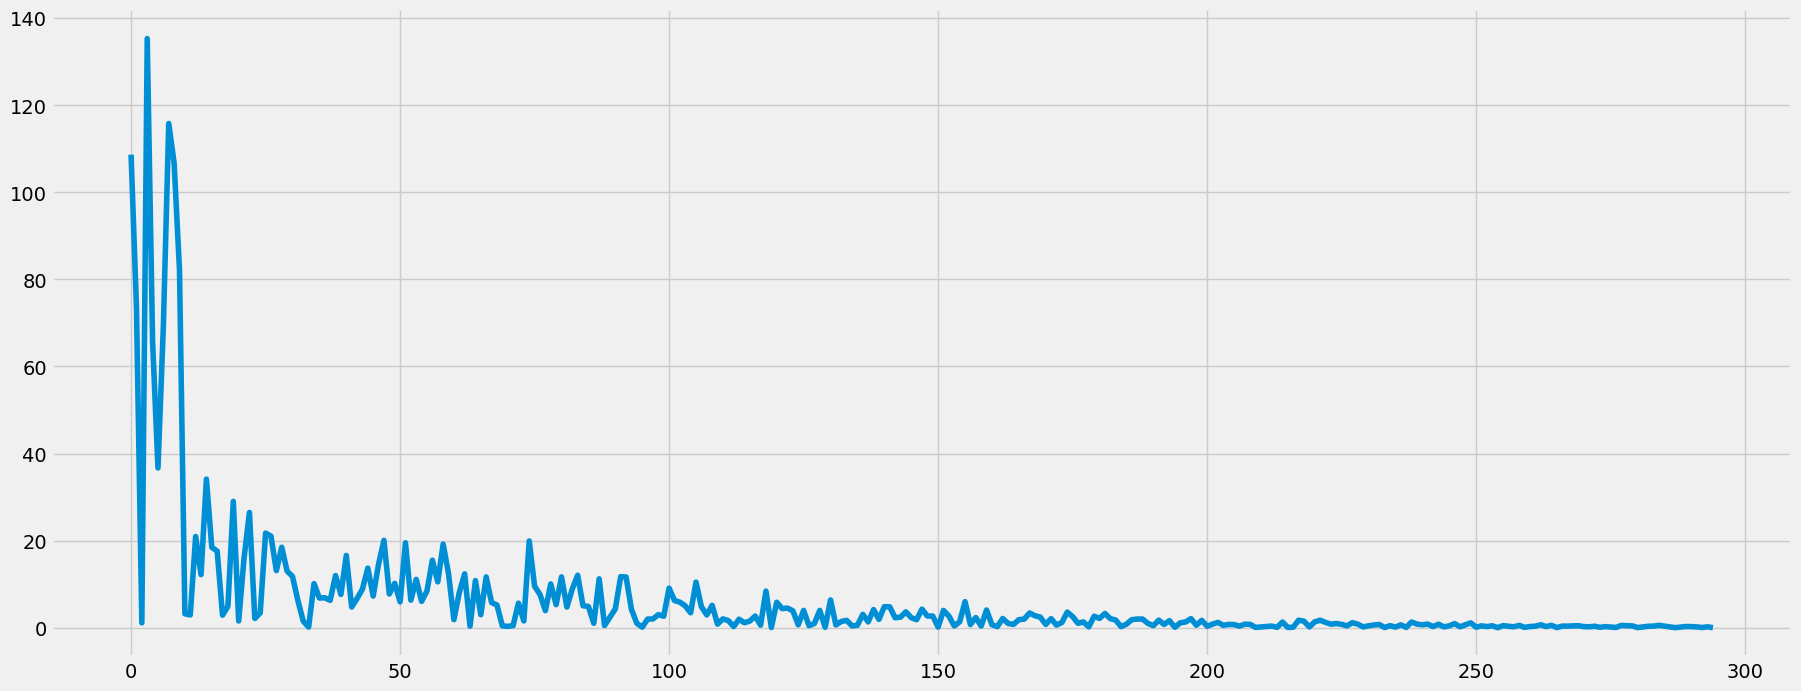

In [20]:
plt.figure(figsize=(20,8))
plt.plot(Griewank_val1) # we see many local minimums
plt.show()

<font color='navy'> We see that with K_ = 10 it takes 295 observation for convergence from the output and the plot above

*****

**Question 2:** Is it a better idea to set $\underline{K} = 100$? Is the convergence faster?

<font color='navy'> We run the same process again but this time we set K_ = 100 and evaluate/compare with the results from K_=10 

In [21]:
%%capture

# Making the warm_up value of K equal to 100
K_=100
x_star2, Griewank_val2 = refined_global_optimizer(K,K_,bounds,tau,seed=seed_num)

In [22]:
x_star2,x_star1

(array([-6.54052610e-09, -1.83506148e-08]),
 array([-1.08691804e-08, -2.78117854e-09]))

In [23]:
print(f'Number of obs to convergence = {len(Griewank_val2)}')
print(f'X-Star value = {griewank(x_star2)}')

Number of obs to convergence = 395
X-Star value = 1.1102230246251565e-16


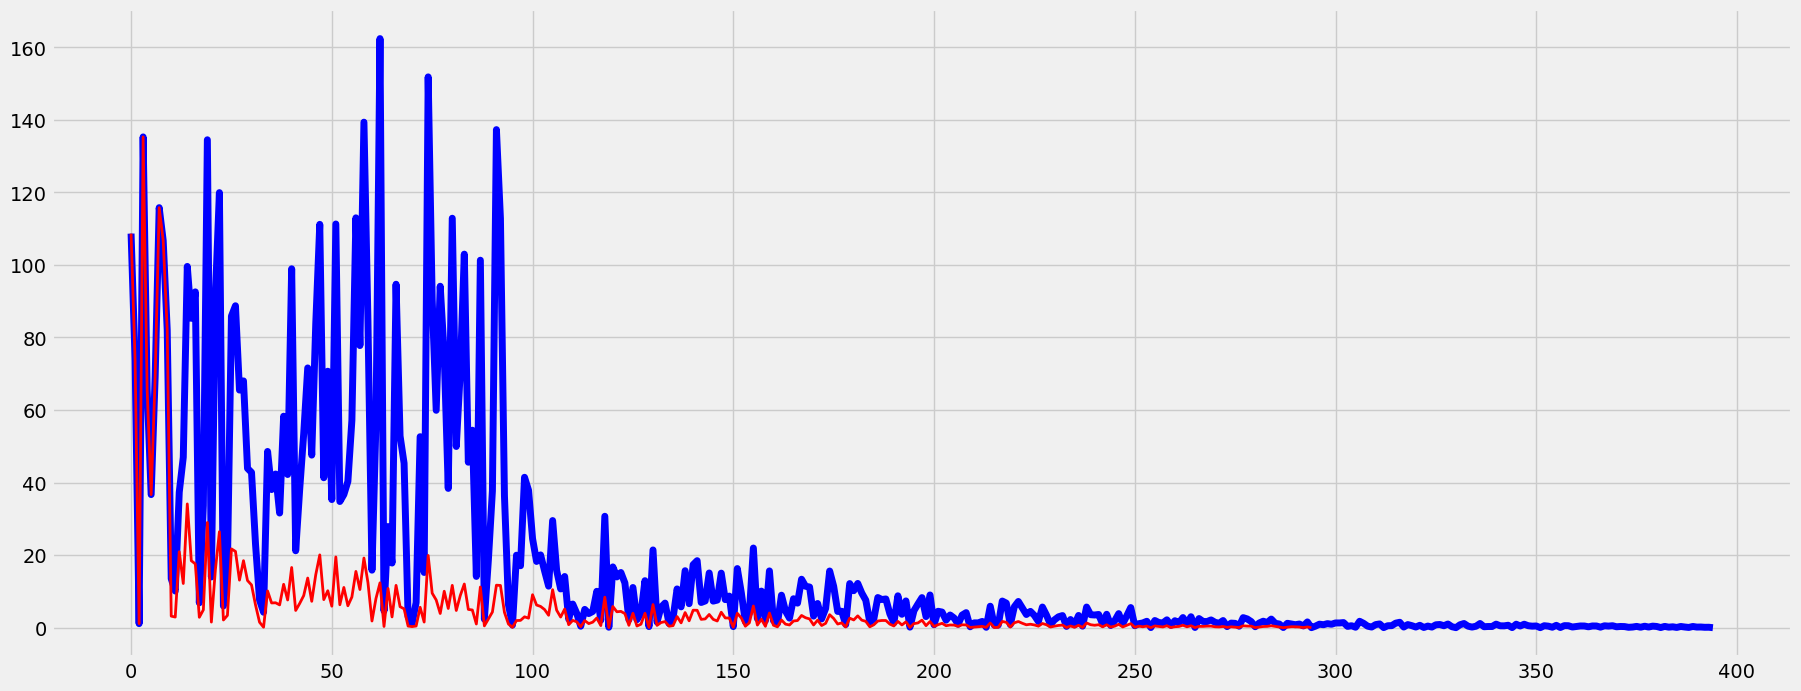

In [24]:
plt.figure(figsize=(20,8))
plt.plot(Griewank_val2,color='blue',linewidth=5) # we see many local minimums
plt.plot(Griewank_val1,color='red',linewidth=2) # we see many local minimums
plt.show()

<font color='navy'> We see that with K_=100 it takes 395 oberservation to converge, hence the convergence has slowed down.
The warm-up iterations help explore the solution space initially, and after K_ warm-up iterations, the optimizer transitions to regular iterations where it uses adjusted initial guesses based on the best solution found so far.
It's clear that there is a trade-off between exploration and exploitation. Increasing $\underline{K}$ too much can lead to excessive exploration, potentially slowing down convergence if the function has a relatively simple landscape with few local minima.

********

<font color='navy'> This part seeks to investigate which K_value that has the fastest converge, as well as showing the importance of keeping seed_number in mind when running the global optimizer

In [25]:
%%capture
# Extra experiment where the minimum warm-up value for the fastest convergence:

# Warm-up interval
K_=np.linspace(5, 200, 40)
convergence_len=[]
convergence=[]

for x in K_:
    x_star2, Griewank_val2 = refined_global_optimizer(K,x,bounds,tau,seed=seed_num)
    convergence_len.append(len(Griewank_val2))
    convergence.append(Griewank_val2)

The warm-up value in the interval with the fastest convergence: 75
The fastest convergence value: 96


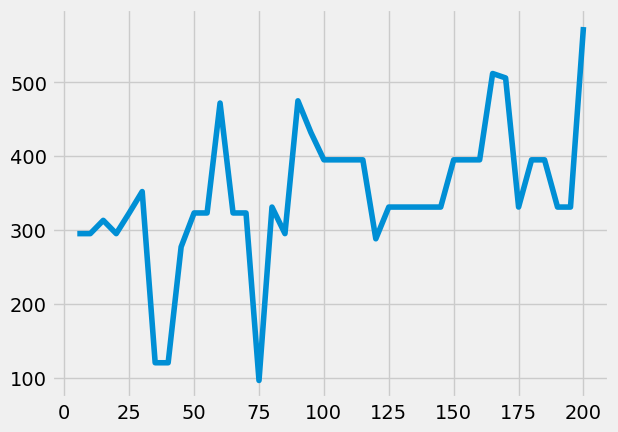

In [26]:
# Finding first optimal warm up value and it's fastest convergence in the given interval above:
print(f'The warm-up value in the interval with the fastest convergence: {convergence_len.index(min(convergence_len))*5+5}')
print(f'The fastest convergence value: {min(convergence_len)}')

# The plot shows the convergence length in the warm-up-interval
plt.plot(K_,convergence_len)
# as you can see the values for fastest convergence is completely random and it also changes if we change seed - therefore it's impossible to tell if it's better or not.
# Of course the warm-up value has an decreasing impact on the totalt K values we test on.

<font color='navy'> From the output above we see that for our seed number the fastest convergence is found when setting the warm up iteration at K_=75 

From the plot, we can also see that for K_=100 it takes just below 400 observation before convergence, the exact number is 395 found earlier
The graph is telling us that there is no clear relationship between convergence and warm up iterations, hence we try to change the seed number in next section and evaluate.

******

<font color='navy'> Below can all the convergence value be seing in a plot for each K_underline, notice the red line is the fastest just below 100 oberservation (96)

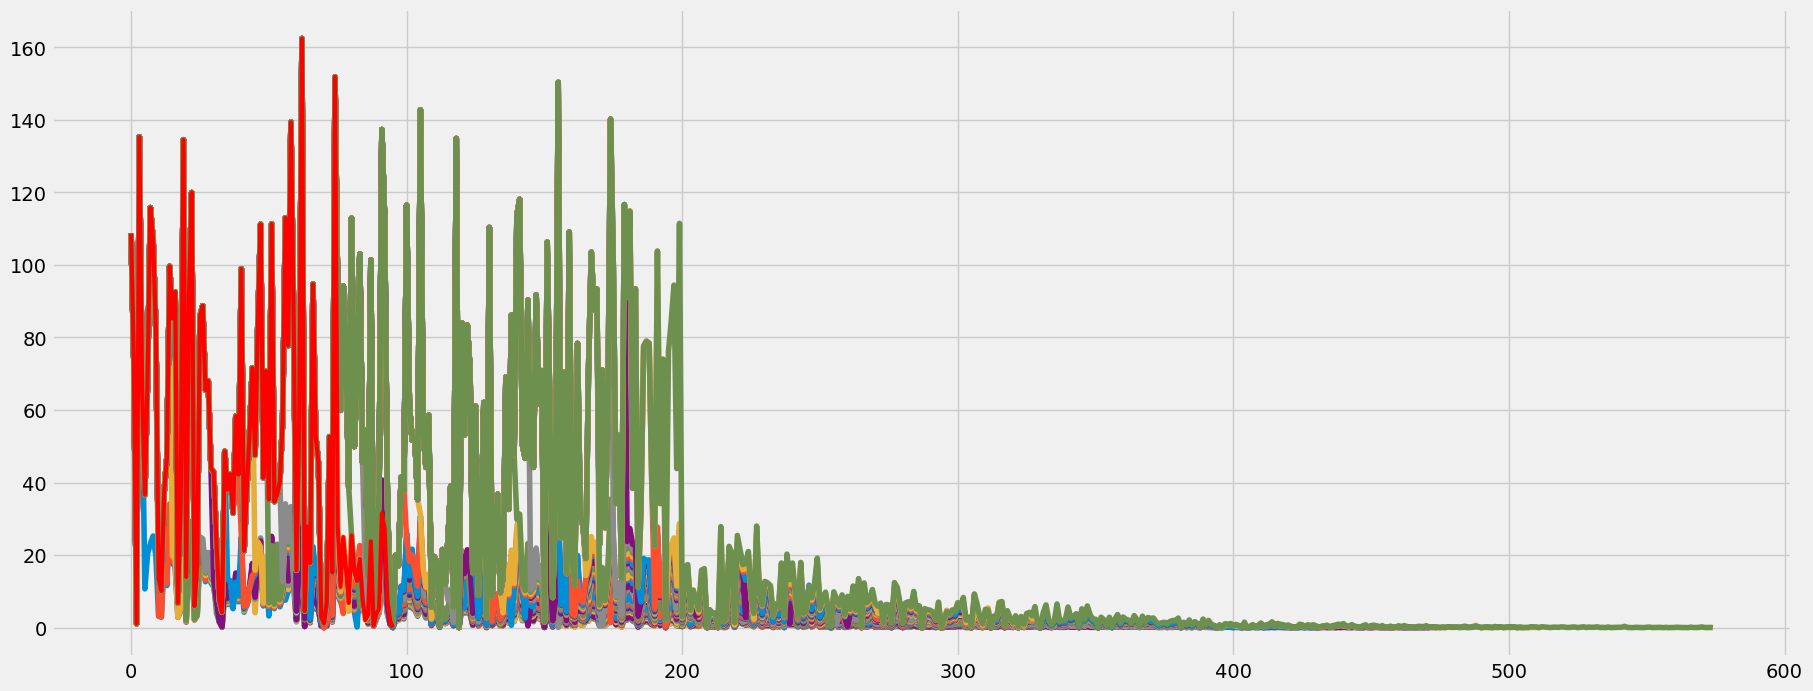

In [27]:
plt.figure(figsize=(20,8))
for x in range(len(K_)):
    plt.plot(convergence[x],linewidth=4)

# Red line is the fastest convergence:
plt.plot(convergence[convergence_len.index(min(convergence_len))],linewidth=3,color="red")
plt.show()

******

<font color='navy'> This section seeks to show that the K_value convergence speed depends on the seed number

In [28]:
%%capture
# Example setting seed to 3000 - here the solution for fastest convergence is faster for the warm-up = 100...
# Therefore we can't conclude if it's faster.

K_=10
x_star1, Griewank_val1 = refined_global_optimizer(K,K_,bounds,tau,seed=3000)
# Making the warm_up value of K equal to 100
K_=100
x_star2, Griewank_val2 = refined_global_optimizer(K,K_,bounds,tau,seed=3000)

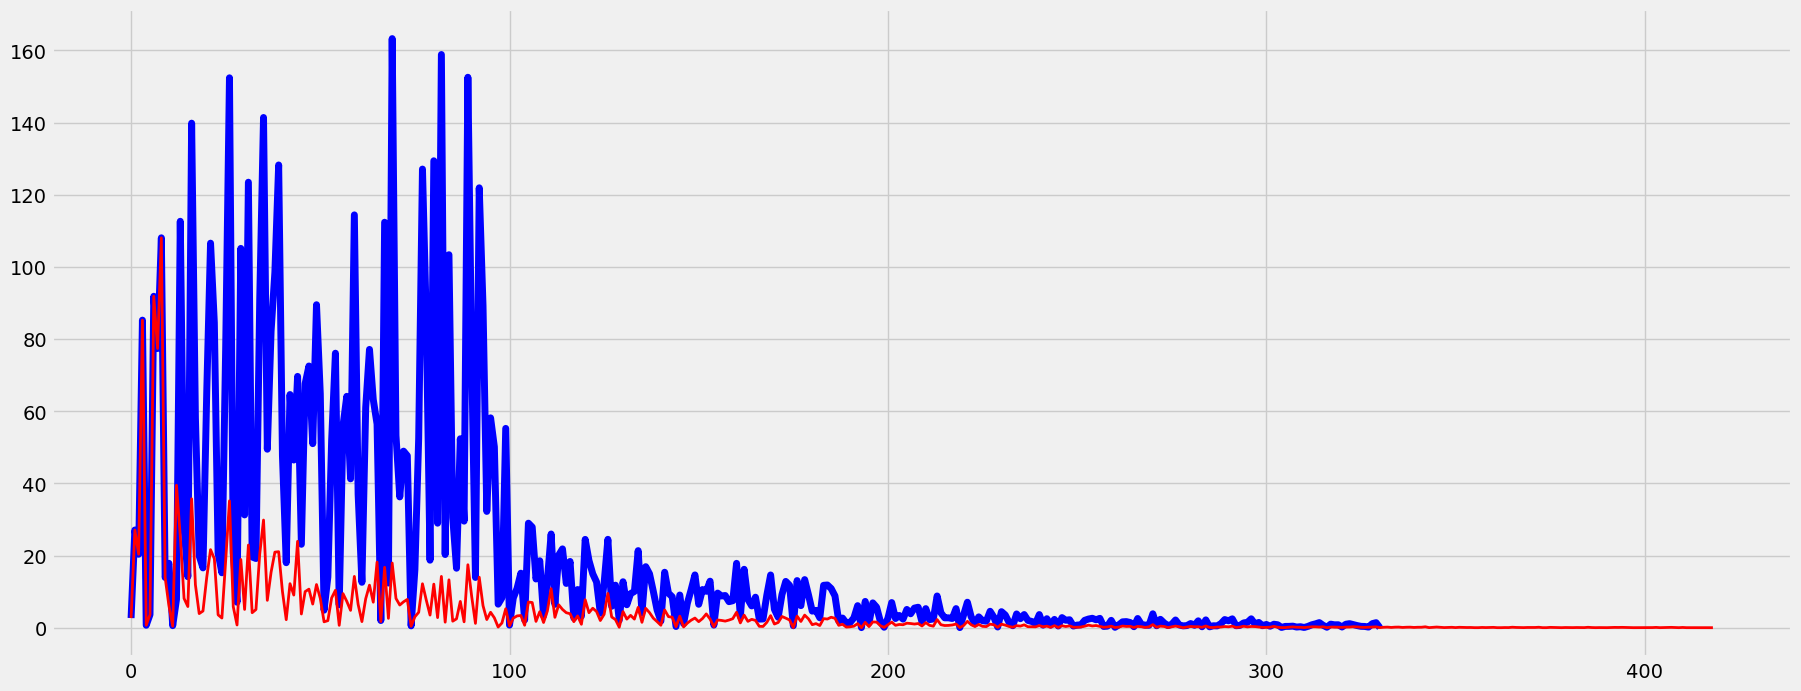

In [29]:
# Proof
plt.figure(figsize=(20,8))
plt.plot(Griewank_val2,color='blue',linewidth=5)
plt.plot(Griewank_val1,color='red',linewidth=2)
plt.show()

<font color='navy'> Hence, changing the seed from 1964 to 3000 leads to the the warm up value with K_=100 converge faster now with a different seed number. 